In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import tensorflow as tf
from tensorflow import keras
from helper_functions import create_tf_data_datasets
from helper_functions import plot_triplet_roc_curve_new
from helper_functions import plot_triplet_training

In [ ]:
#new_model = keras.models.load_model('path_to_my_model')

# Triplet Loss

In [9]:
class DistanceLayer(keras.layers.Layer):
    """
    This layer computes the distance between the anchor/positive and anchor/negative embedding
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [10]:
class SiameseModel(keras.models.Model):
    
    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")
        
    def call(self, inputs):
        return self.siamese_network(inputs)
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    
    @property
    def metrics(self):
        return [self.loss_tracker]

In [36]:
def half_deep_writer_model(emb_size, input_shape):
    inputs = keras.layers.Input(input_shape)

    x = keras.layers.Conv2D(96, kernel_size=5, strides=2, activation='relu')(inputs)
    x = keras.layers.MaxPooling2D(3, strides=2)(x)

    x = keras.layers.Conv2D(256, kernel_size=3, activation='relu')(x)
    x = keras.layers.MaxPooling2D(3, strides=2)(x)

    x = keras.layers.Conv2D(384, kernel_size=3, activation='relu')(x)
    x = keras.layers.Conv2D(384, kernel_size=3, activation='relu')(x)
    x = keras.layers.Conv2D(256, kernel_size=3, activation='relu')(x)
    x = keras.layers.MaxPooling2D(3, strides=2)(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    output = keras.layers.Dense(emb_size)(x)

    embedding_half_deep_writer = keras.models.Model(inputs, output)
    
    return embedding_half_deep_writer
    

## Patches 224x224x3, Embedding Size = 128

In [33]:
anchor_images_path = "npz_datasets/pairs_20k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [37]:
input_shape = (height,width,3)
emb_size = 128
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [42]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [43]:
siamese_224_224_3_128 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [44]:
siamese_224_224_3_128 = SiameseModel(siamese_224_224_3_128)
siamese_224_224_3_128.compile(optimizer="Adam")
history_siamese_224_224_3_128 = siamese_224_224_3_128.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 27s 479ms/step - loss: 1.1693 - val_loss: 0.2765
Epoch 2/20
56/56 [==============================] - 27s 475ms/step - loss: 0.2445 - val_loss: 0.1828
Epoch 3/20
56/56 [==============================] - 27s 477ms/step - loss: 0.1965 - val_loss: 0.2213
Epoch 4/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1869 - val_loss: 0.2111
Epoch 5/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1731 - val_loss: 0.1850
Epoch 6/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1645 - val_loss: 0.1625
Epoch 7/20
56/56 [==============================] - 27s 477ms/step - loss: 0.1693 - val_loss: 0.1683
Epoch 8/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1600 - val_loss: 0.1826
Epoch 9/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1420 - val_loss: 0.1494
Epoch 10/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1467 - val_lo

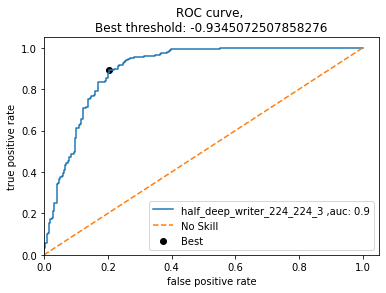

In [45]:
plot_triplet_roc_curve_new(model=siamese_224_224_3_128, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_224_224_3_128")

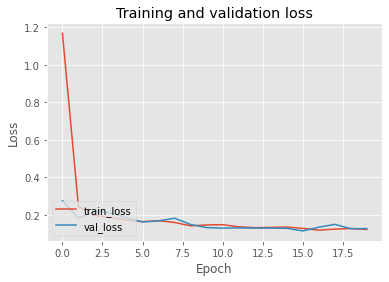

In [48]:
plot_triplet_training(history_siamese_224_224_3_128)

In [70]:
siamese_224_224_3_128.save('saved_models/half_deep_writer_224_224_3_128',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_128/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_128/assets


## Patches 224x224x3, Embedding Size = 256

In [49]:
anchor_images_path = "npz_datasets/pairs_20k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [50]:
input_shape = (height,width,3)
emb_size = 256
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [51]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [52]:
siamese_224_224_3_256 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [53]:
siamese_224_224_3_256 = SiameseModel(siamese_224_224_3_256)
siamese_224_224_3_256.compile(optimizer="Adam")
history_siamese_224_224_3_256 = siamese_224_224_3_256.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 27s 476ms/step - loss: 3.5329 - val_loss: 0.2939
Epoch 2/20
56/56 [==============================] - 27s 474ms/step - loss: 0.2599 - val_loss: 0.1914
Epoch 3/20
56/56 [==============================] - 27s 475ms/step - loss: 0.2086 - val_loss: 0.2092
Epoch 4/20
56/56 [==============================] - 27s 476ms/step - loss: 0.2088 - val_loss: 0.2163
Epoch 5/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1985 - val_loss: 0.1902
Epoch 6/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1799 - val_loss: 0.1690
Epoch 7/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1700 - val_loss: 0.1533
Epoch 8/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1565 - val_loss: 0.1435
Epoch 9/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1606 - val_loss: 0.1384
Epoch 10/20
56/56 [==============================] - 27s 475ms/step - loss: 0.1559 - val_lo

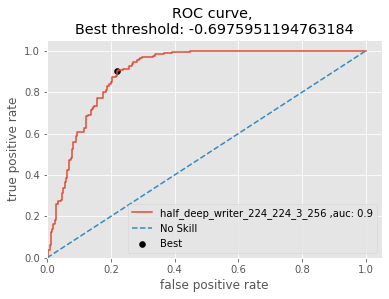

In [54]:
plot_triplet_roc_curve_new(model=siamese_224_224_3_256, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_224_224_3_256")

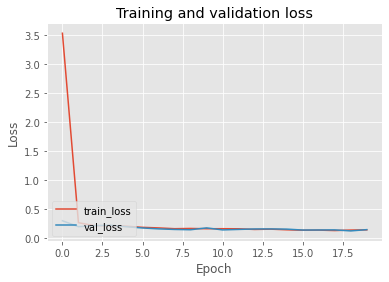

In [55]:
plot_triplet_training(history_siamese_224_224_3_256)

In [71]:
siamese_224_224_3_256.save('saved_models/half_deep_writer_224_224_3_256',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_256/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_256/assets


## Patches 224x224x3, Embedding Size = 512

In [80]:
anchor_images_path = "npz_datasets/pairs_20k_224_224/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [81]:
input_shape = (height,width,3)
emb_size = 512
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [82]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [83]:
siamese_224_224_3_512 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [84]:
siamese_224_224_3_512 = SiameseModel(siamese_224_224_3_512)
siamese_224_224_3_512.compile(optimizer="Adam")
history_siamese_224_224_3_512 = siamese_224_224_3_512.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 27s 479ms/step - loss: 5.4647 - val_loss: 0.3040
Epoch 2/20
56/56 [==============================] - 27s 479ms/step - loss: 0.2937 - val_loss: 0.2537
Epoch 3/20
56/56 [==============================] - 27s 478ms/step - loss: 0.2589 - val_loss: 0.2133
Epoch 4/20
56/56 [==============================] - 27s 476ms/step - loss: 0.2059 - val_loss: 0.1729
Epoch 5/20
56/56 [==============================] - 27s 479ms/step - loss: 0.1823 - val_loss: 0.1692
Epoch 6/20
56/56 [==============================] - 27s 479ms/step - loss: 0.1886 - val_loss: 0.1552
Epoch 7/20
56/56 [==============================] - 27s 478ms/step - loss: 0.1698 - val_loss: 0.1384
Epoch 8/20
56/56 [==============================] - 27s 476ms/step - loss: 0.1547 - val_loss: 0.1402
Epoch 9/20
56/56 [==============================] - 27s 477ms/step - loss: 0.1533 - val_loss: 0.1639
Epoch 10/20
56/56 [==============================] - 27s 478ms/step - loss: 0.1571 - val_lo

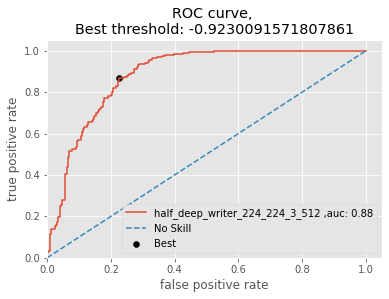

In [85]:
plot_triplet_roc_curve_new(model=siamese_224_224_3_512, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_224_224_3_512")

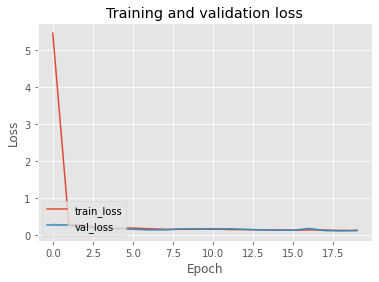

In [86]:
plot_triplet_training(history_siamese_224_224_3_512)

In [87]:
siamese_224_224_3_512.save('saved_models/half_deep_writer_224_224_3_512',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_512/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_3_512/assets


## Patches 224x224, Embedding Size = 128

In [95]:
anchor_images_path = "npz_datasets/pairs_20k_224_224_gray/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224_gray/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [96]:
input_shape = (height,width, 1)
emb_size = 128
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [97]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [98]:
siamese_224_224_128 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [99]:
siamese_224_224_128 = SiameseModel(siamese_224_224_128)
siamese_224_224_128.compile(optimizer="Adam")
history_siamese_224_224_128 = siamese_224_224_128.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 34s 590ms/step - loss: 0.5841 - val_loss: 0.3141
Epoch 2/20
56/56 [==============================] - 22s 387ms/step - loss: 0.3035 - val_loss: 0.3174
Epoch 3/20
56/56 [==============================] - 22s 388ms/step - loss: 0.2976 - val_loss: 0.2950
Epoch 4/20
56/56 [==============================] - 22s 388ms/step - loss: 0.2957 - val_loss: 0.2930
Epoch 5/20
56/56 [==============================] - 22s 388ms/step - loss: 0.2705 - val_loss: 0.2906
Epoch 6/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2567 - val_loss: 0.2776
Epoch 7/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2657 - val_loss: 0.2750
Epoch 8/20
56/56 [==============================] - 22s 390ms/step - loss: 0.2620 - val_loss: 0.2626
Epoch 9/20
56/56 [==============================] - 22s 390ms/step - loss: 0.2487 - val_loss: 0.2590
Epoch 10/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2544 - val_lo

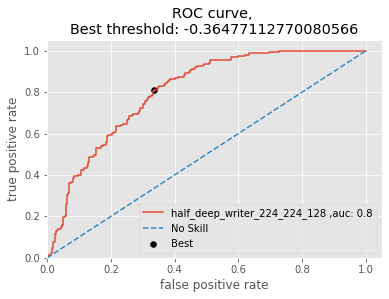

In [100]:
plot_triplet_roc_curve_new(model=siamese_224_224_128, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_224_224_128")

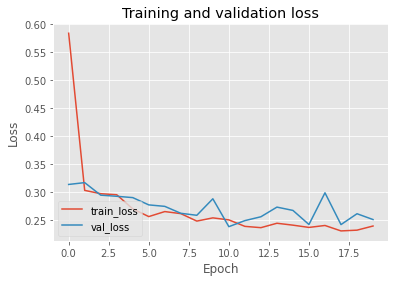

In [101]:
plot_triplet_training(history_siamese_224_224_128)

In [102]:
siamese_224_224_128.save('saved_models/half_deep_writer_224_224_128',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_128/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_128/assets


## Patches 224x224, Embedding Size = 256

In [103]:
anchor_images_path = "npz_datasets/pairs_20k_224_224_gray/anchor"
positive_images_path = "npz_datasets/pairs_20k_224_224_gray/positive"
width, height = 224, 224
batch_size = 256
train_dataset, val_dataset = create_tf_data_datasets(anchor_images_path,
                                                     positive_images_path, 
                                                     height, width, 
                                                     batch_size)

In [104]:
input_shape = (height,width, 1)
emb_size = 256
embedding_half_deep_writer = half_deep_writer_model(emb_size=emb_size, input_shape=input_shape)

In [105]:
anchor_input = keras.layers.Input(shape=input_shape)
positive_input = keras.layers.Input(shape=input_shape)
negative_input = keras.layers.Input(shape=input_shape)

distances = DistanceLayer()(
    embedding_half_deep_writer(anchor_input),
    embedding_half_deep_writer(positive_input),
    embedding_half_deep_writer(negative_input),
)

In [106]:
siamese_224_224_256 = keras.models.Model(inputs=[anchor_input,
                                              positive_input,
                                              negative_input], outputs=distances)

In [107]:
siamese_224_224_256 = SiameseModel(siamese_224_224_256)
siamese_224_224_256.compile(optimizer="Adam")
history_siamese_224_224_256 = siamese_224_224_256.fit(train_dataset, epochs=20, 
                                                 validation_data=val_dataset)

Epoch 1/20
56/56 [==============================] - 22s 389ms/step - loss: 0.6829 - val_loss: 0.3396
Epoch 2/20
56/56 [==============================] - 22s 389ms/step - loss: 0.3302 - val_loss: 0.3105
Epoch 3/20
56/56 [==============================] - 22s 389ms/step - loss: 0.3060 - val_loss: 0.3099
Epoch 4/20
56/56 [==============================] - 22s 389ms/step - loss: 0.3051 - val_loss: 0.3017
Epoch 5/20
56/56 [==============================] - 22s 390ms/step - loss: 0.2983 - val_loss: 0.2858
Epoch 6/20
56/56 [==============================] - 22s 390ms/step - loss: 0.2602 - val_loss: 0.2545
Epoch 7/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2633 - val_loss: 0.2894
Epoch 8/20
56/56 [==============================] - 22s 389ms/step - loss: 0.2624 - val_loss: 0.2590
Epoch 9/20
56/56 [==============================] - 22s 387ms/step - loss: 0.2530 - val_loss: 0.2689
Epoch 10/20
56/56 [==============================] - 22s 386ms/step - loss: 0.2494 - val_lo

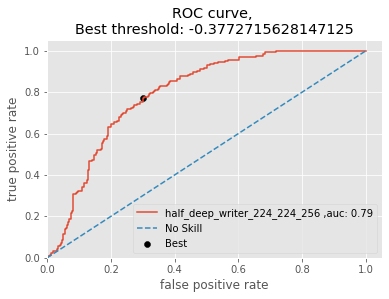

In [108]:
plot_triplet_roc_curve_new(model=siamese_224_224_256, 
                           dataset=next(iter(val_dataset)), 
                           model_name="half_deep_writer_224_224_256")

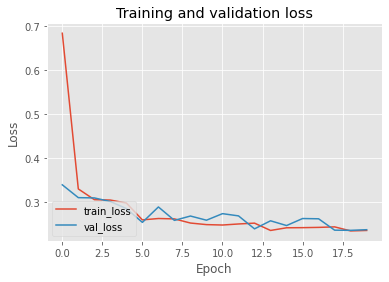

In [109]:
plot_triplet_training(history_siamese_224_224_256)

In [110]:
siamese_224_224_256.save('saved_models/half_deep_writer_224_224_256',save_format='tf')

INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_256/assets


INFO:tensorflow:Assets written to: saved_models/half_deep_writer_224_224_256/assets


## Patches 224x224, Embedding Size = 512